<a href="https://colab.research.google.com/github/Byeon-MJ/CreditCard_Overdue_Prediction/blob/main/CreditCard_Overdue_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module Import

In [ ]:
!pip install catboost
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 53 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 9.5 MB/s 
     |████████████████████████████████| 210 kB 86.8 MB/s 
     |████████████████████████████████| 81 kB 10.5 MB/s 
     |████████████████████████████████| 78 kB 8.6 MB/s 
     |████████████████████████████████| 50 kB 8.2 MB/s 
     |████████████████████████████████| 147 kB 66.3 MB/s 
     |████████████████████████████████| 112 kB 53.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=75b3a9456c79f743a43cea622805f7db6c5a0dcc92808adce77703cf6eebde6f
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Attempting uninstall: importlib-metadata
    Found 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import missingno as msno

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from hyperopt import hp, STATUS_OK, fmin, tpe, Trials
import optuna
from optuna.samplers import TPESampler

In [ ]:
print(np.__version__)
print(pd.__version__)
print(sklearn.__version__)

1.21.6
1.3.5
1.0.2


# Dataset Load

In [ ]:
train = pd.read_csv('https://raw.githubusercontent.com/Byeon-MJ/ML_Mini_Project_CreditCard/main/dataset/train.csv')

In [ ]:
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0
26453,26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NaN,2.0,-47.0,2.0
26454,26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0
26455,26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [ ]:
train.describe()

,index,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
count,26457.000000,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,13228.000000,0.428658,1.873065e+05,-15958.053899,59068.750728,1.0,0.224742,0.294251,0.091280,2.196848,-26.123294,1.519560
std,7637.622372,0.747326,1.018784e+05,4201.589022,137475.427503,0.0,0.417420,0.455714,0.288013,0.916717,16.559550,0.702283
min,0.000000,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,6614.000000,0.000000,1.215000e+05,-19431.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000,1.000000
50%,13228.000000,0.000000,1.575000e+05,-15547.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000,2.000000
75%,19842.000000,1.000000,2.250000e+05,-12446.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000,2.000000
max,26456.000000,19.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,2.000000


In [ ]:
train.describe(include='O')

,gender,car,reality,income_type,edu_type,family_type,house_type,occyp_type
count,26457,26457,26457,26457,26457,26457,26457,18286
unique,2,2,2,5,5,5,6,18
top,F,N,Y,Working,Secondary / secondary special,Married,House / apartment,Laborers
freq,17697,16410,17830,13645,17995,18196,23653,4512


# EDA & Visualization

## credit

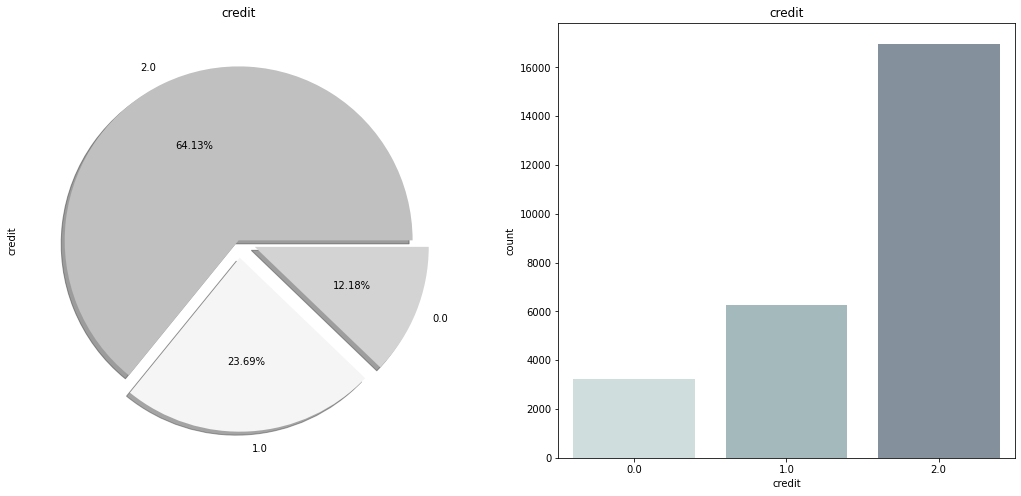

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(18,8))
# palette = sns.color_palette('Greys_r')
palette = sns.color_palette('bone_r')
train['credit'].value_counts().plot.pie(explode=[0,0.1, 0.1],autopct='%1.2f%%',ax=ax[0],shadow=True, colors =['silver', 'whitesmoke','lightgrey'])
ax[0].set_title('credit')
ax[0].set_ylabel('credit')
sns.countplot('credit',data=train,ax=ax[1], palette=palette)
ax[1].set_title('credit')
plt.show()

## gender

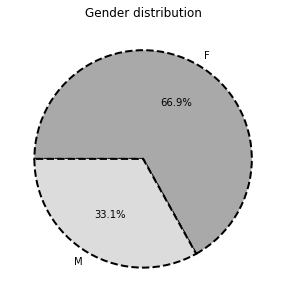

In [ ]:
df1= train.groupby('gender').count()['index']
fig = plt.figure(figsize=(5,5))
fig.set_facecolor('white')
plt.pie(df1, labels=df1.index,colors=['darkgray','gainsboro'], startangle=180,autopct='%1.1f%%',counterclock=False,wedgeprops = {'edgecolor':'k','linestyle':'--','linewidth':2})
plt.title('Gender distribution')
plt.show()

## car

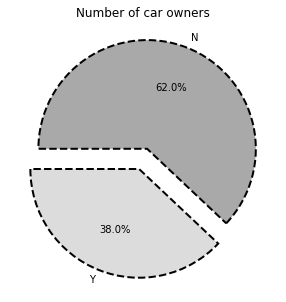

In [ ]:
df1= train.groupby('car').count()['index']
explode = (0.1, 0.1)
fig = plt.figure(figsize=(5,5)) ## 캔버스 생성
fig.set_facecolor('white')
plt.pie(df1, labels=df1.index,colors=['darkgray','gainsboro'],explode=explode, startangle=180,autopct='%1.1f%%',counterclock=False,wedgeprops = {'edgecolor':'k','linestyle':'--','linewidth':2})
plt.title('Number of car owners')
plt.show()

## reality

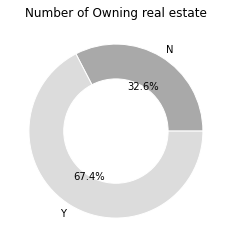

In [ ]:
df1= train.groupby('reality').count()['index'] #reality (부동산) groupby후 시각화
my_circle=plt.Circle((0,0),0.6,color='white')
fig = plt.figure()
plt.pie(df1,labels=df1.index,wedgeprops={'linewidth':1,'edgecolor':'white'},autopct='%1.1f%%',textprops={'color':"black"}, colors=['darkgray','gainsboro'])
p=plt.gcf()
p.gca().add_artist(my_circle)
fig.patch.set_facecolor('white')
plt.title('Number of Owning real estate')
plt.show()

## income_type

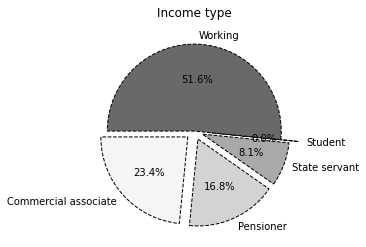

In [ ]:
it = train.groupby('income_type').count()['index']
explode = (0.1, 0.1, 0.1, 0.2, 0.0)
colors = ['whitesmoke', 'lightgray', 'darkgray', 'grey', 'dimgray']
plt.pie(it,explode=explode,colors=colors, labels=it.index, startangle=180,autopct='%1.1f%%',wedgeprops = {'edgecolor':'k','linestyle':'--','linewidth':1},textprops={'color':"black"})
title_color = 'black'
plt.title('Income type',color=title_color)
plt.show()

## edu_type

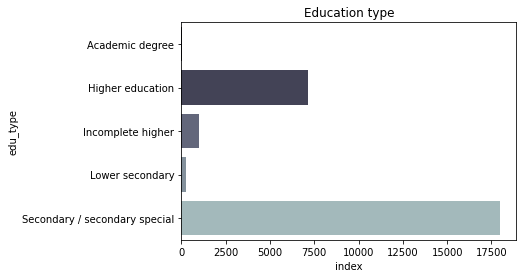

In [ ]:
et = train.groupby('edu_type').count()['index']
palette = sns.color_palette('bone')
et = et.reset_index()
sns.barplot(data=et, y="edu_type", x="index", orient='h',palette=palette)
title_color = 'black'
plt.title('Education type',color=title_color)
plt.show()

## family_type

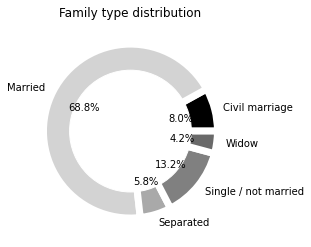

In [ ]:
ft = train.groupby('family_type').count()['index']
my_circle=plt.Circle((0,0),0.7,color='white')
colors = ['black', 'lightgray', 'darkgray', 'grey', 'dimgray']
fig = plt.figure()
plt.pie(ft,labels=ft.index,colors=colors, wedgeprops={'linewidth':7,'edgecolor':'white'},autopct='%1.1f%%',textprops={'color':"black"})
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Family type distribution')
plt.show()

## credit & gender

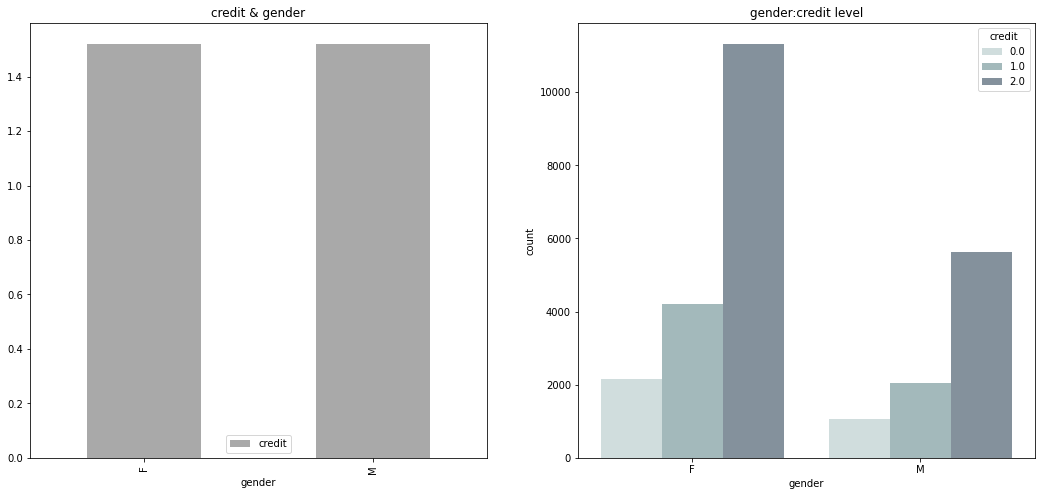

In [ ]:
palette = sns.color_palette('bone_r')
f,ax=plt.subplots(1,2,figsize=(18,8))
train[['gender','credit']].groupby(['gender']).mean().plot.bar(ax=ax[0], color='darkgray')
ax[0].set_title('credit & gender')
sns.countplot('gender',hue='credit',data=train,ax=ax[1],palette=palette)
ax[1].set_title('gender:credit level')
plt.show()

# Data Pre-Processing
**종속 변수**
* credit : 
        사용자의 신용카드 대금 연체를 기준으로 한 신용도
        
        => 낮을수록 높은 신용의 신용카드 사용자를 의미함

**독립 변수**
* gender
* car : 차량 소유 여부 
* reality : 부동산 소유 여부
* child_num : 자녀 수
* income_total : 연간 소득
* income_type : 소득 분류
        ['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']
* edu_type : 교육 수준
         ['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']
* family_type : 결혼 여부
        ['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']
* house_type : 생활 방식
        ['Municipal apartment', 'House / apartment', 'With parents', 'Co-op apartment', 'Rented apartment', 'Office apartment']
* DAYS_BIRTH : 출생일
        데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미
* DAYS_EMPLOYED : 업무 시작일, 
        데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미
    
        양수 값은 고용되지 않은 상태를 의미함
* FLAG_MOBIL : 핸드폰 소유 여부
* work_phone : 업무용 전화 소유 여부
* phone : 전화 소유 여부
* email : 이메일 소유 여부
* occyp_type : 직업 유형
* family_size : 가족 규모
* begin_month : 신용카드 발급 월
        데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미


## needless Col
* index, FLAG_MOBIL

### index

In [ ]:
if 'index' in train.columns: 
    train.drop('index', axis=1, inplace=True)

### FLAG_MOBIL
값이 전부 '1'로 같아서 버려도 되는 컬럼

In [ ]:
train['FLAG_MOBIL'].unique()

array([1])

In [ ]:
if 'FLAG_MOBIL' in train.columns: 
    train.drop('FLAG_MOBIL', axis=1, inplace=True)

In [ ]:
train.columns

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'work_phone', 'phone', 'email', 'occyp_type', 'family_size',
       'begin_month', 'credit'],
      dtype='object')

## Missing Value

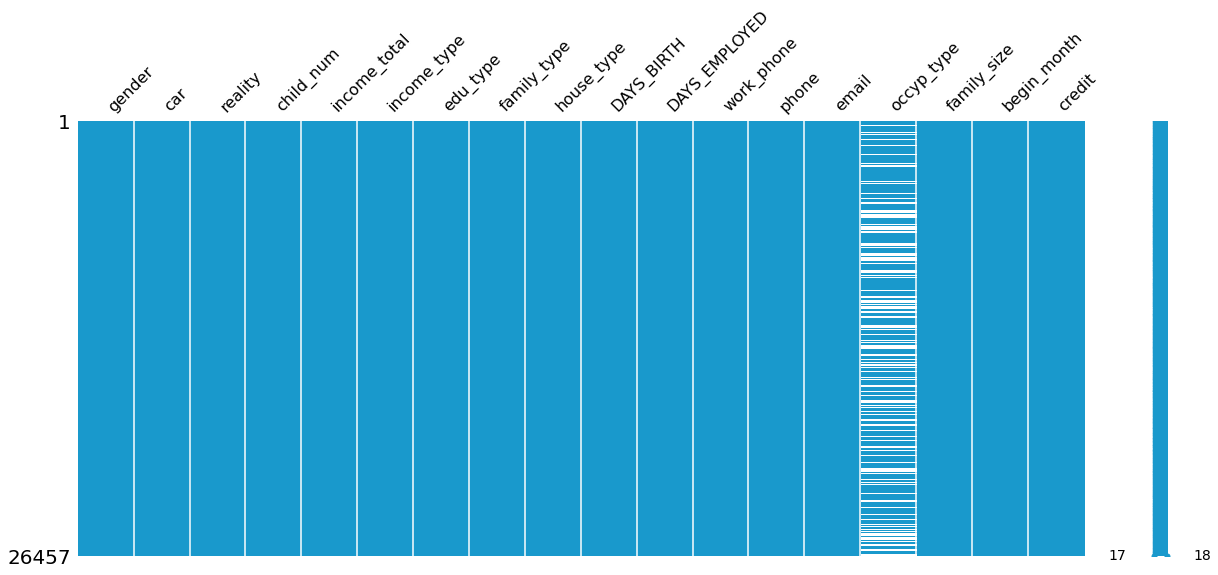

In [ ]:
msno.matrix(df = train, color=(0.1, 0.6, 0.8), figsize=(20, 8))
plt.show()

In [ ]:
train.isna().sum()

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [ ]:
train.isna().sum() / len(train)

gender           0.000000
car              0.000000
reality          0.000000
child_num        0.000000
income_total     0.000000
income_type      0.000000
edu_type         0.000000
family_type      0.000000
house_type       0.000000
DAYS_BIRTH       0.000000
DAYS_EMPLOYED    0.000000
work_phone       0.000000
phone            0.000000
email            0.000000
occyp_type       0.308841
family_size      0.000000
begin_month      0.000000
credit           0.000000
dtype: float64

### occyp_type
* null 값이 30% 정도이므로 컬럼 삭제
* 추후 성능이 개선되지 않으면 바꿔볼 것
    * 직업유형 'unknown' 으로 바꿔주기
    * 경력이 없고 직업군도 없으면 no_work등으로 추가 처리

In [ ]:
train['occyp_type'].unique()

array([nan, 'Laborers', 'Managers', 'Sales staff',
       'High skill tech staff', 'Core staff', 'Drivers', 'Medicine staff',
       'Accountants', 'Realty agents', 'Security staff', 'Cleaning staff',
       'Private service staff', 'Cooking staff', 'Secretaries',
       'HR staff', 'IT staff', 'Low-skill Laborers',
       'Waiters/barmen staff'], dtype=object)

In [ ]:
if 'occyp_type' in train.columns: 
    train.drop('occyp_type', axis=1, inplace=True)

## Outlier

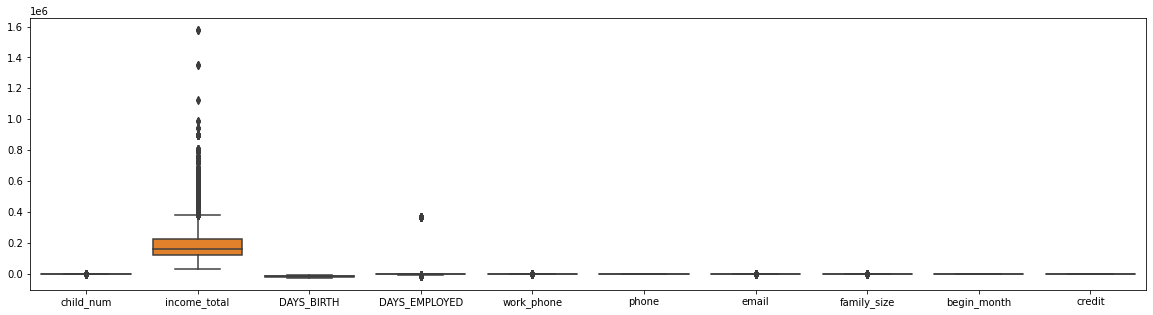

In [ ]:
plt.figure(figsize=(20,5))
sns.boxplot(data=train)
plt.show()

In [ ]:
train.describe().columns

Index(['child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'work_phone', 'phone', 'email', 'family_size', 'begin_month', 'credit'],
      dtype='object')

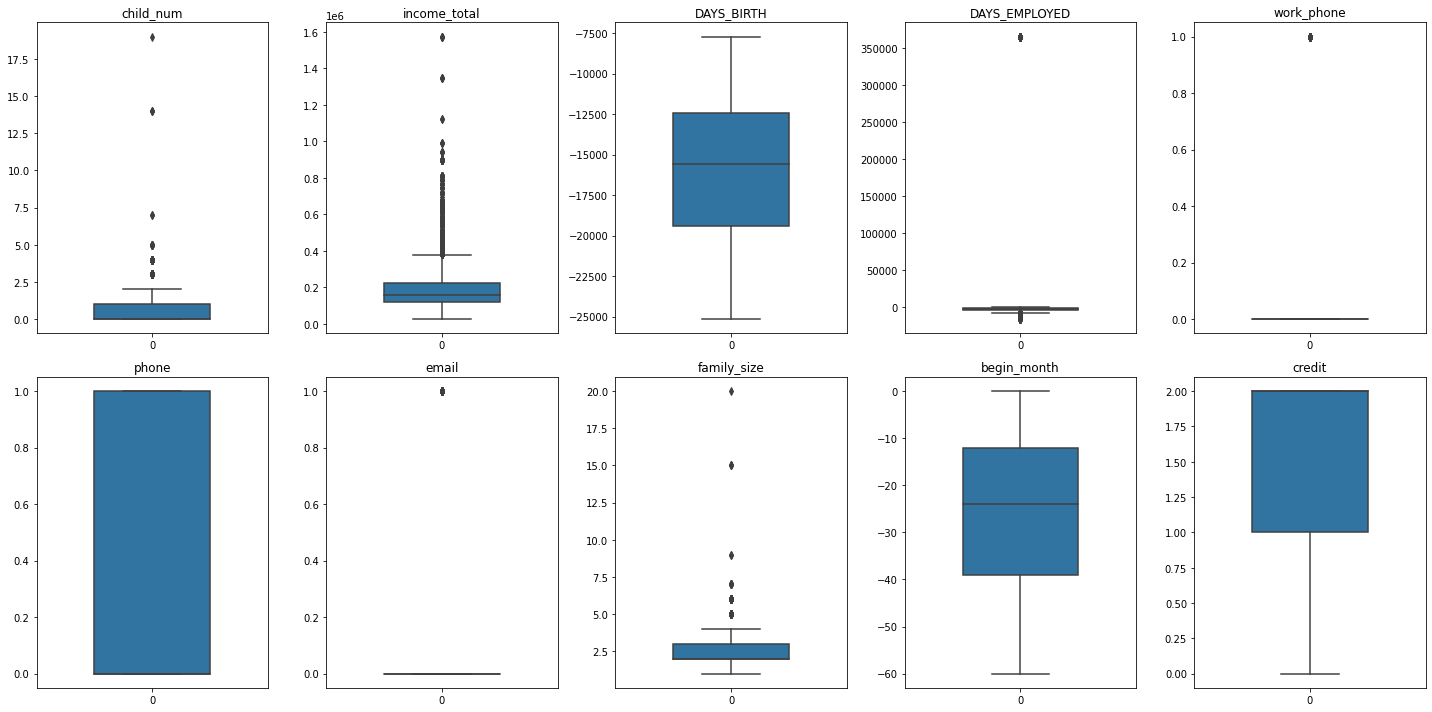

In [ ]:
fig = plt.figure(figsize=(20, 10))

for i, col in enumerate(train.describe().columns):
    plt.subplot(2, 5, i+1)
    plt.title(col)
    sns.boxplot(data=train[col], width=0.5)
    
fig.tight_layout()
plt.show()

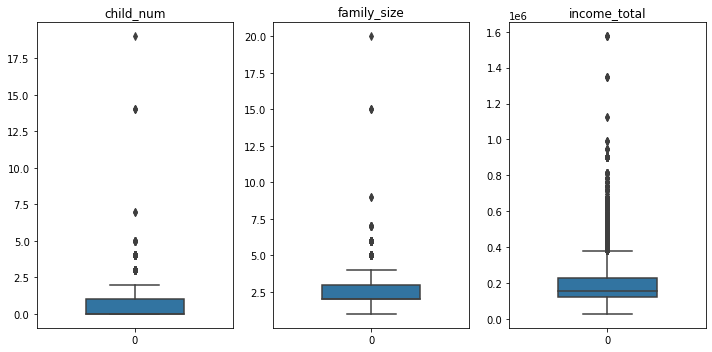

In [ ]:
cols = ['child_num', 'family_size', 'income_total']

fig = plt.figure(figsize=(10, 5))

for i, col in enumerate(cols):
    plt.subplot(1, 3, i+1)
    plt.title(col)
    sns.boxplot(data=train[col], width=0.5)
    
fig.tight_layout()
plt.show()

### child_num
* family_size와 높은 상관관계를 보여 컬럼 삭제

In [ ]:
train.corr()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit
child_num,1.000000,0.032186,0.332816,-0.228159,0.051521,-0.010555,0.016120,0.890530,-0.007229,0.004081
income_total,0.032186,1.000000,0.064155,-0.166478,-0.034207,0.019013,0.089882,0.023839,-0.018047,0.008555
DAYS_BIRTH,0.332816,0.064155,1.000000,-0.616776,0.178752,-0.029247,0.111238,0.298108,0.057306,-0.025187
DAYS_EMPLOYED,-0.228159,-0.166478,-0.616776,1.000000,-0.241827,-0.007749,-0.091090,-0.223077,0.007964,-0.003798
work_phone,0.051521,-0.034207,0.178752,-0.241827,1.000000,0.310256,-0.031048,0.068705,-0.008563,-0.003134
phone,-0.010555,0.019013,-0.029247,-0.007749,0.310256,1.000000,0.012494,-0.000132,-0.014286,0.003452
email,0.016120,0.089882,0.111238,-0.091090,-0.031048,0.012494,1.000000,0.016122,0.002320,0.014812
family_size,0.890530,0.023839,0.298108,-0.223077,0.068705,-0.000132,0.016122,1.000000,-0.023032,0.008227
begin_month,-0.007229,-0.018047,0.057306,0.007964,-0.008563,-0.014286,0.002320,-0.023032,1.000000,-0.147477
credit,0.004081,0.008555,-0.025187,-0.003798,-0.003134,0.003452,0.014812,0.008227,-0.147477,1.000000


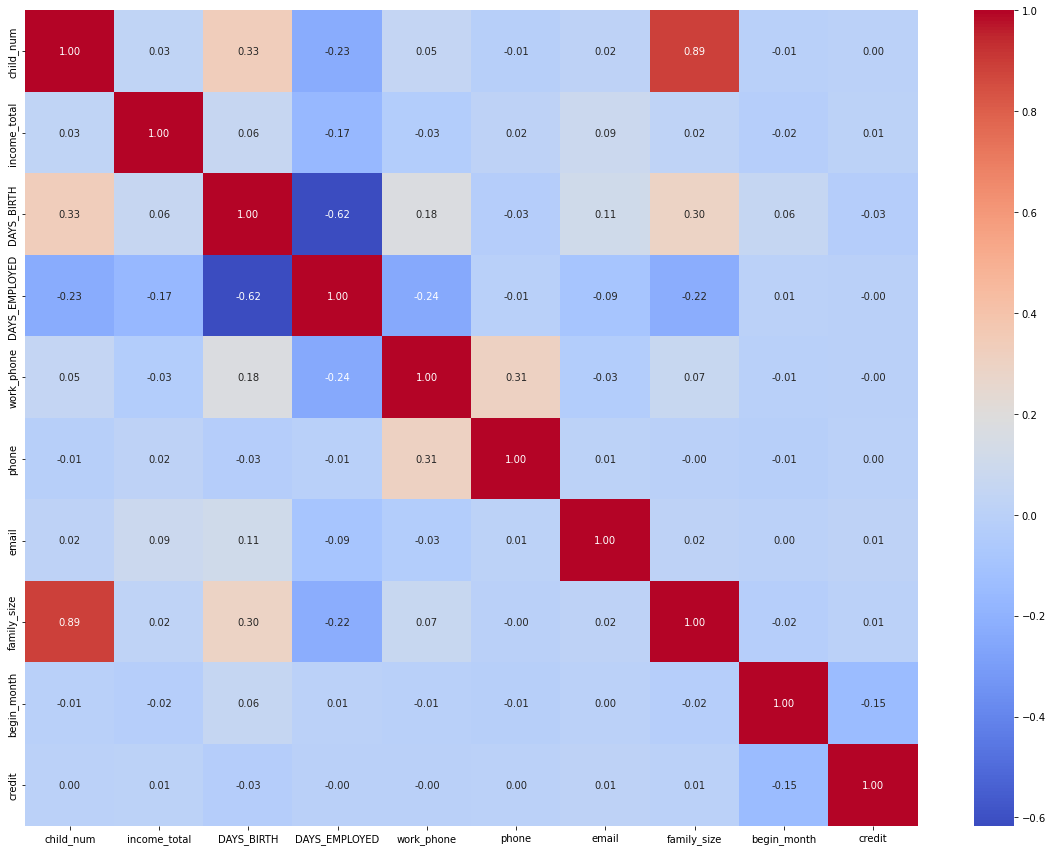

In [ ]:
plt.figure(figsize=(20, 15))
sns.heatmap(data = train.corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.show()

In [ ]:
train['child_num'].unique()

array([ 0,  1,  2,  3,  4,  5, 14, 19,  7])

In [ ]:
train['child_num'].value_counts()

0     18340
1      5386
2      2362
3       306
4        47
5        10
14        3
7         2
19        1
Name: child_num, dtype: int64

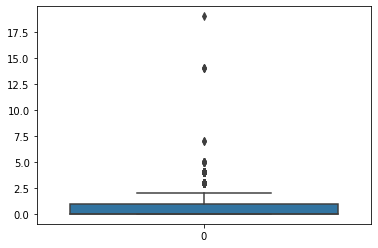

In [ ]:
sns.boxplot(data=train['child_num'])

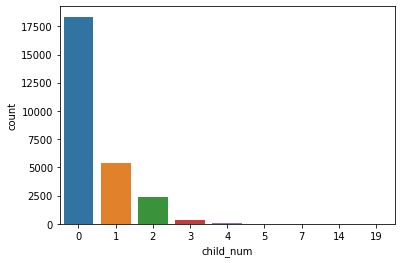

In [ ]:
sns.countplot(data=train, x='child_num')

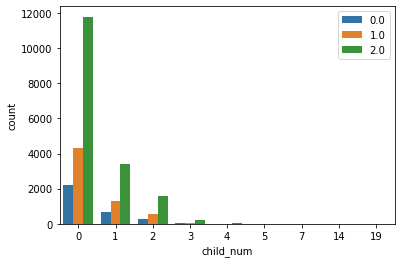

In [ ]:
sns.countplot(data=train, x='child_num', hue='credit')
plt.legend(loc='upper right')
plt.show()

In [ ]:
if 'child_num' in train.columns: 
    train.drop('child_num', axis=1, inplace=True)

### family_size
* child_num 보다 더 넓은 의미를 가지므로 남겨두고 이상치 처리
* 6보다 큰 raw 삭제

In [ ]:
train['family_size'].unique()

array([ 2.,  3.,  4.,  1.,  5.,  6.,  7., 15., 20.,  9.])

In [ ]:
train['family_size'].value_counts()

2.0     14106
1.0      5109
3.0      4632
4.0      2260
5.0       291
6.0        44
7.0         9
15.0        3
9.0         2
20.0        1
Name: family_size, dtype: int64

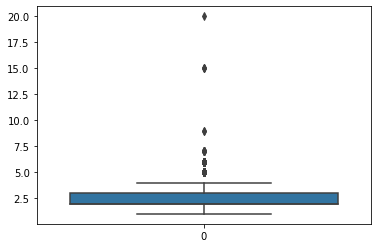

In [ ]:
sns.boxplot(data=train['family_size'])

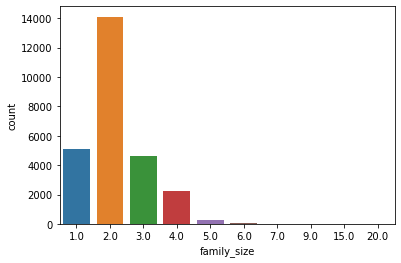

In [ ]:
sns.countplot(data=train, x='family_size')

In [ ]:
train = train[train['family_size'] < 6]

In [ ]:
train = train.reset_index(drop=True)

In [ ]:
train

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit
0,F,N,N,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,0,0,0,2.0,-6.0,1.0
1,F,N,Y,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,0,0,1,3.0,-5.0,1.0
2,M,Y,Y,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,0,1,0,2.0,-22.0,2.0
3,F,N,Y,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,0,1,0,2.0,-37.0,0.0
4,F,Y,Y,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,0,0,0,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26393,F,N,N,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,0,0,0,4.0,-2.0,1.0
26394,F,N,Y,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,0,0,0,2.0,-47.0,2.0
26395,F,Y,N,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,0,0,0,2.0,-25.0,2.0
26396,M,N,Y,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,0,0,0,1.0,-59.0,2.0


### income_mean
* 수입(income_total)을 가족 수로 나눠서 평균 수입 구하기

In [ ]:
train['income_mean'] = train['income_total'] / train['family_size']

In [ ]:
train.head()

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit,income_mean
0,F,N,N,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,0,0,0,2.0,-6.0,1.0,101250.0
1,F,N,Y,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,0,0,1,3.0,-5.0,1.0,82500.0
2,M,Y,Y,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,0,1,0,2.0,-22.0,2.0,225000.0
3,F,N,Y,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,0,1,0,2.0,-37.0,0.0,101250.0
4,F,Y,Y,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,0,0,0,2.0,-26.0,2.0,78750.0


## Label Encoding

### Type Cols
: income_type, edu_type, family_type, house_type

In [ ]:
train.columns

Index(['gender', 'car', 'reality', 'income_total', 'income_type', 'edu_type',
       'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'work_phone', 'phone', 'email', 'family_size', 'begin_month', 'credit',
       'income_mean'],
      dtype='object')

In [ ]:
type_cols = ['income_type', 'edu_type', 'family_type', 'house_type']
for col in type_cols:
    print(f'{col} :', train[col].unique())
    print(train[col].value_counts())

income_type : ['Commercial associate' 'Working' 'State servant' 'Pensioner' 'Student']
Working                 13603
Commercial associate     6191
Pensioner                4449
State servant            2148
Student                     7
Name: income_type, dtype: int64
edu_type : ['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
Secondary / secondary special    17955
Higher education                  7149
Incomplete higher                 1015
Lower secondary                    256
Academic degree                     23
Name: edu_type, dtype: int64
family_type : ['Married' 'Civil marriage' 'Separated' 'Single / not married' 'Widow']
Married                 18142
Single / not married     3495
Civil marriage           2123
Separated                1535
Widow                    1103
Name: family_type, dtype: int64
house_type : ['Municipal apartment' 'House / apartment' 'With parents'
 'Co-op apartment' 'Rented apartment' 'Office a

In [ ]:
le = LabelEncoder()

In [ ]:
for col in type_cols:
    train[col] = le.fit_transform(train[col])
    print(f'{col} :', train[col].unique())

income_type : [0 4 2 1 3]
edu_type : [1 4 2 3 0]
family_type : [1 0 2 3 4]
house_type : [2 1 5 0 4 3]


### Binary Cols
: gender, car, reality

In [ ]:
bin_cols = ['gender', 'car', 'reality']

for col in bin_cols:
    print(f'{col} :', train[col].unique())
    print(train[col].value_counts())

gender : ['F' 'M']
F    17656
M     8742
Name: gender, dtype: int64
car : ['N' 'Y']
N    16389
Y    10009
Name: car, dtype: int64
reality : ['N' 'Y']
Y    17792
N     8606
Name: reality, dtype: int64


In [ ]:
le = LabelEncoder()

In [ ]:
for col in bin_cols:
    train[col] = le.fit_transform(train[col])
    print(f'{col} :', train[col].unique())
    print(train[col].value_counts())

gender : [0 1]
0    17656
1     8742
Name: gender, dtype: int64
car : [0 1]
0    16389
1    10009
Name: car, dtype: int64
reality : [0 1]
1    17792
0     8606
Name: reality, dtype: int64


: work_phone, phone, email

In [ ]:
bin2_cols = ['work_phone', 'phone', 'email']

for col in bin2_cols:
    print(f'{col} :', train[col].unique())
    print(train[col].value_counts())

work_phone : [0 1]
0    20464
1     5934
Name: work_phone, dtype: int64
phone : [0 1]
0    18621
1     7777
Name: phone, dtype: int64
email : [0 1]
0    23983
1     2415
Name: email, dtype: int64


## Date assoicated Cols
* DAYS_EMPLOYED
* DAYS_BIRTH
* begin_month

### DAYS_EMPLOYED
* 0보다 크면 무직으로 판단, 0으로 변경

In [ ]:
train[train['DAYS_EMPLOYED'] > 0]

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit,income_mean
14,0,0,1,157500.0,1,4,3,1,-22922,365243,0,1,0,1.0,-41.0,2.0,157500.0
18,0,0,1,216000.0,1,4,1,1,-23113,365243,0,0,0,2.0,-37.0,2.0,108000.0
21,0,0,0,157500.0,1,4,1,1,-21253,365243,0,1,0,2.0,-7.0,2.0,78750.0
24,0,0,0,202500.0,1,4,3,1,-22361,365243,0,1,0,1.0,-5.0,2.0,202500.0
46,0,0,0,135000.0,1,4,4,1,-21100,365243,0,1,0,1.0,-24.0,2.0,135000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26372,0,0,1,225000.0,1,4,4,1,-21151,365243,0,0,1,1.0,-60.0,1.0,225000.0
26373,0,1,1,72000.0,1,4,1,1,-22314,365243,0,1,0,2.0,-17.0,1.0,36000.0
26380,0,0,1,67500.0,1,4,1,1,-19238,365243,0,0,0,2.0,-57.0,2.0,33750.0
26382,0,0,1,90000.0,1,2,2,1,-24129,365243,0,0,0,1.0,-43.0,2.0,90000.0


In [ ]:
train.loc[train['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'] = 0

### Date associated Cols
* Absolute Value

In [ ]:
date_cols = ['DAYS_EMPLOYED', 'DAYS_BIRTH', 'begin_month']

for col in date_cols:
    train[col] = np.abs(train[col])

### DAYS_BIRTH
* 세대(generation)으로 변경, 범주형 변수로

In [ ]:
train['DAYS_BIRTH'].nunique()

6615

In [ ]:
train['age_gen'] = (train['DAYS_BIRTH'] // 365) // 10

In [ ]:
train[['age_gen']]

,age_gen
0,3
1,3
2,5
3,4
4,4
...,...
26393,3
26394,4
26395,2
26396,2


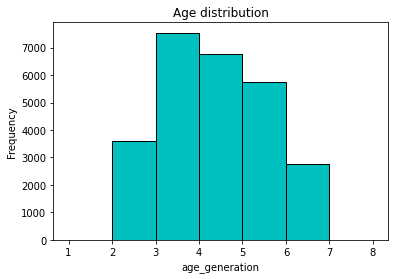

In [ ]:
train['age_gen'].plot.hist(bins=range(1,9),color='c', edgecolor='k')
plt.xlabel('age_generation')
plt.title('Age distribution')
plt.show()

## Correlation

In [ ]:
train.corr()

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit,income_mean,age_gen
gender,1.000000,0.362228,-0.049630,0.198413,0.103117,0.006534,-0.102237,0.067716,-0.201427,-0.033378,0.065151,-0.026740,0.000068,0.115223,-0.007987,0.001659,0.065040,-0.198079
car,0.362228,1.000000,-0.016652,0.213606,0.047568,-0.104896,-0.124076,0.019214,-0.156366,0.004595,0.026761,-0.012453,0.019319,0.149797,0.029890,0.008209,0.061609,-0.150824
reality,-0.049630,-0.016652,1.000000,0.035355,-0.049085,0.011975,0.027963,-0.178137,0.130366,-0.038611,-0.207814,-0.065171,0.051105,-0.007462,-0.003982,-0.008537,0.039281,0.121084
income_total,0.198413,0.213606,0.035355,1.000000,-0.074920,-0.226623,-0.005879,-0.004559,-0.064392,0.087137,-0.034153,0.019272,0.089867,0.025935,0.018141,0.008247,0.718856,-0.064899
income_type,0.103117,0.047568,-0.049085,-0.074920,1.000000,0.057544,-0.050752,0.033456,-0.210896,0.189527,0.162694,0.004663,-0.019816,0.106438,-0.002431,-0.007710,-0.103042,-0.198251
edu_type,0.006534,-0.104896,0.011975,-0.226623,0.057544,1.000000,0.008602,-0.039582,0.166598,-0.017145,-0.024442,-0.045647,-0.095718,-0.045133,-0.014138,0.013286,-0.148198,0.159396
family_type,-0.102237,-0.124076,0.027963,-0.005879,-0.050752,0.008602,1.000000,0.006945,0.104224,-0.052236,-0.065673,-0.014811,-0.015630,-0.566930,-0.030780,-0.005561,0.468001,0.093615
house_type,0.067716,0.019214,-0.178137,-0.004559,0.033456,-0.039582,0.006945,1.000000,-0.210714,-0.022250,0.031300,-0.019356,0.013260,0.009675,-0.030498,-0.009392,0.007520,-0.202244
DAYS_BIRTH,-0.201427,-0.156366,0.130366,-0.064392,-0.210896,0.166598,0.104224,-0.210714,1.000000,-0.020187,-0.179065,0.028940,-0.111691,-0.304892,0.057098,0.024761,0.071683,0.970580
DAYS_EMPLOYED,-0.033378,0.004595,-0.038611,0.087137,0.189527,-0.017145,-0.052236,-0.022250,-0.020187,1.000000,0.109325,0.042261,0.003112,0.055471,0.082963,0.023074,0.029627,-0.009628


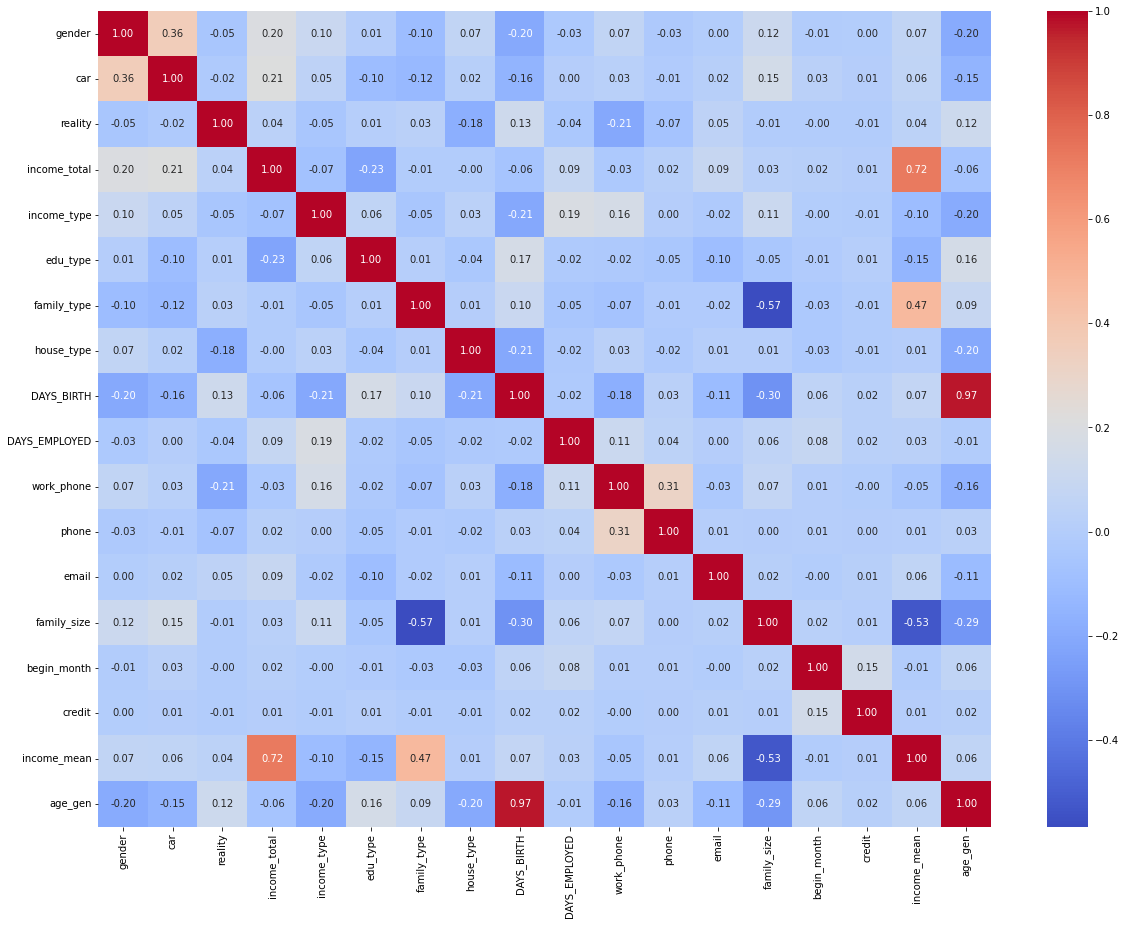

In [ ]:
plt.figure(figsize=(20, 15))
sns.heatmap(data = train.corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.show()

# Modeling - before Feature Engineering
* Decision Tree
* RandomForest
* Xgboost
* LightGBM
* Catboost

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26398 entries, 0 to 26397
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26398 non-null  int64  
 1   car            26398 non-null  int64  
 2   reality        26398 non-null  int64  
 3   income_total   26398 non-null  float64
 4   income_type    26398 non-null  int64  
 5   edu_type       26398 non-null  int64  
 6   family_type    26398 non-null  int64  
 7   house_type     26398 non-null  int64  
 8   DAYS_BIRTH     26398 non-null  int64  
 9   DAYS_EMPLOYED  26398 non-null  int64  
 10  work_phone     26398 non-null  int64  
 11  phone          26398 non-null  int64  
 12  email          26398 non-null  int64  
 13  family_size    26398 non-null  float64
 14  begin_month    26398 non-null  float64
 15  credit         26398 non-null  float64
 16  income_mean    26398 non-null  float64
 17  age_gen        26398 non-null  int64  
dtypes: flo

In [ ]:
data_X = train.drop('credit', axis=1)
data_y = train[['credit']]

In [ ]:
data_X.shape, data_y.shape

((26398, 17), (26398, 1))

## Train, Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, random_state=21)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21118, 17), (5280, 17), (21118, 1), (5280, 1))

## model creator

In [ ]:
# clf = [dt, rf, xgb, lgb, cat]
def clf_create(clf, seed):
    if clf == 'dt':
        model = DecisionTreeClassifier(random_state=seed)
    elif clf == 'rf':
        model = RandomForestClassifier(random_state=seed)
    elif clf == 'xgb':
        model = XGBClassifier(random_state=seed)
    elif clf == 'lgb':
        model = LGBMClassifier(random_state=seed)
    elif clf == 'cat':
        model = CatBoostClassifier(random_state=seed)

    if clf == 'cat':
        model.fit(X_train, y_train, verbose=False)
    else:
        model.fit(X_train, y_train)

    pred_train = model.predict(X_train)    
    pred_test = model.predict(X_test)
    
    acc_score_train = accuracy_score(y_train, pred_train)
    acc_score_test = accuracy_score(y_test, pred_test)

    f1_weighted_train = f1_score(y_train, pred_train, average='weighted')
    f1_weighted_test = f1_score(y_test, pred_test, average='weighted')

    return [acc_score_train, acc_score_test, f1_weighted_train, f1_weighted_test]

## DecisionTree Classifier

In [ ]:
dt_clf = DecisionTreeClassifier(random_state=21)

In [ ]:
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=21)

In [ ]:
dt_pred = dt_clf.predict(X_test)

In [ ]:
dt_acc_score = accuracy_score(y_test, dt_pred)
dt_acc_score

0.6081439393939394

In [ ]:
dt_f1_weighted = f1_score(y_test, dt_pred, average='weighted')
dt_f1_weighted

0.6113708026208027

In [ ]:
dt_acc_score_train, dt_acc_score_test, dt_f1_weighted_train, dt_f1_weighted_test = clf_create('dt', 21)

In [ ]:
print(dt_acc_score_train)
print(dt_acc_score_test)
print(dt_f1_weighted_train)
print(dt_f1_weighted_test)

0.9776493986172933
0.6081439393939394
0.9778380831025346
0.6113708026208027


## RandomForest Classifier

In [ ]:
rf_acc_score_train, rf_acc_score_test, rf_f1_weighted_train, rf_f1_weighted_test =  clf_create('rf', 21)

In [ ]:
print(rf_acc_score_train)
print(rf_acc_score_test)
print(rf_f1_weighted_train)
print(rf_f1_weighted_test)

0.9776493986172933
0.7034090909090909
0.9775771755864944
0.6850133861950232


## XGBoost Classifier

In [ ]:
xgb_acc_score_train, xgb_acc_score_test, xgb_f1_weighted_train, xgb_f1_weighted_test = clf_create('xgb', 21)

In [ ]:
print(xgb_acc_score_train)
print(xgb_acc_score_test)
print(xgb_f1_weighted_train)
print(xgb_f1_weighted_test)

0.6950468794393408
0.6867424242424243
0.6077327740023379
0.5966640676806025


## LightGBM Classifier

In [ ]:
lgb_acc_score_train, lgb_acc_score_test, lgb_f1_weighted_train, lgb_f1_weighted_test = clf_create('lgb', 21)

In [ ]:
print(lgb_acc_score_train)
print(lgb_acc_score_test)
print(lgb_f1_weighted_train)
print(lgb_f1_weighted_test)

0.7158348328440193
0.6941287878787878
0.6447680057077486
0.6134730010275589


## CatBoost Classifier

In [ ]:
cat_acc_score_train, cat_acc_score_test, cat_f1_weighted_train, cat_f1_weighted_test = clf_create('cat', 21)

In [ ]:
print(cat_acc_score_train)
print(cat_acc_score_test)
print(cat_f1_weighted_train)
print(cat_f1_weighted_test)

0.7526754427502604
0.7024621212121213
0.7079131066704714
0.6383483434278725


# Feature Engineering
* 한 컬럼당 한 사람이 아닐 수 있음! 고유한 사람의 수는 더 적을 가능성, ID 조합 찾기
        동일인물임을 결정하는 5가지 변수
        gender : 성별
        income_total : 연간 소득
        income_type : 소득 분류
        DAYS_BIRTH : 출생일
        DAYS_EMPLOYED : 업무 시작일
* 다중공선성을 고려하여 상관관계가 높은 컬럼 제거

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26398 entries, 0 to 26397
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26398 non-null  int64  
 1   car            26398 non-null  int64  
 2   reality        26398 non-null  int64  
 3   income_total   26398 non-null  float64
 4   income_type    26398 non-null  int64  
 5   edu_type       26398 non-null  int64  
 6   family_type    26398 non-null  int64  
 7   house_type     26398 non-null  int64  
 8   DAYS_BIRTH     26398 non-null  int64  
 9   DAYS_EMPLOYED  26398 non-null  int64  
 10  work_phone     26398 non-null  int64  
 11  phone          26398 non-null  int64  
 12  email          26398 non-null  int64  
 13  family_size    26398 non-null  float64
 14  begin_month    26398 non-null  float64
 15  credit         26398 non-null  float64
 16  income_mean    26398 non-null  float64
 17  age_gen        26398 non-null  int64  
dtypes: flo

## before_EMPLOYED
* 고용되기 전까지의 일수
* 월, 주

In [ ]:
train['before_EMPLOYED'] = train['DAYS_BIRTH'] - train['DAYS_EMPLOYED']
train['income_total_befofeEMP_ratio'] = train['income_total'] / train['before_EMPLOYED']
train['before_EMPLOYED_month'] = np.floor(train['before_EMPLOYED'] / 30) - ((np.floor(train['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
train['before_EMPLOYED_week'] = np.floor(train['before_EMPLOYED'] / 7) - ((np.floor(train['before_EMPLOYED'] / 7) / 4).astype(int) * 4)

## EMPLOYED
* 근속년수
* 월, 주

In [ ]:
train['EMPOLYED'] = train['DAYS_EMPLOYED'] // 365
train['DAYS_EMPLOYED_month'] = np.floor(train['DAYS_EMPLOYED'] / 30) - ((np.floor(train['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
train['DAYS_EMPLOYED_week'] = np.floor(train['DAYS_EMPLOYED'] / 7) - ((np.floor(train['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

## ID
* 각 컬럼의 값들을 더해서 고유한 사람을 파악
* 한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외함

In [ ]:
train['ID'] = train['gender'].astype(str) + '-' +\
             train['income_total'].astype(str) + '-' +\
             train['income_type'].astype(str) + '-' +\
             train['DAYS_BIRTH'].astype(str) + '-' +\
             train['DAYS_EMPLOYED'].astype(str)

In [ ]:
le = LabelEncoder()

In [ ]:
train['ID'] = le.fit_transform(train['ID'])

In [ ]:
train['ID'].unique()

array([2965, 3709, 8401, ..., 4114, 6668, 5141])

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26398 entries, 0 to 26397
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        26398 non-null  int64  
 1   car                           26398 non-null  int64  
 2   reality                       26398 non-null  int64  
 3   income_total                  26398 non-null  float64
 4   income_type                   26398 non-null  int64  
 5   edu_type                      26398 non-null  int64  
 6   family_type                   26398 non-null  int64  
 7   house_type                    26398 non-null  int64  
 8   DAYS_BIRTH                    26398 non-null  int64  
 9   DAYS_EMPLOYED                 26398 non-null  int64  
 10  work_phone                    26398 non-null  int64  
 11  phone                         26398 non-null  int64  
 12  email                         26398 non-null  int64  
 13  f

## Del Cols
* 파생변수와 다중공선성을 보이는 컬럼 삭제

In [ ]:
train.columns

Index(['gender', 'car', 'reality', 'income_total', 'income_type', 'edu_type',
       'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'work_phone', 'phone', 'email', 'family_size', 'begin_month', 'credit',
       'income_mean', 'age_gen', 'before_EMPLOYED',
       'income_total_befofeEMP_ratio', 'before_EMPLOYED_month',
       'before_EMPLOYED_week', 'EMPOLYED', 'DAYS_EMPLOYED_month',
       'DAYS_EMPLOYED_week', 'ID'],
      dtype='object')

In [ ]:
del_cols = ['DAYS_BIRTH', 'DAYS_EMPLOYED']
if 'DAYS_BIRTH' in train.columns:
    train.drop(del_cols, axis=1, inplace=True)

# Modeling - after Feature Engineering

In [ ]:
data_X = train.drop('credit', axis=1)
data_y = train[['credit']]

In [ ]:
data_X.shape, data_y.shape

((26398, 23), (26398, 1))

## Train, Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, random_state=21)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21118, 23), (5280, 23), (21118, 1), (5280, 1))

## DecisionTree Classifier

In [ ]:
dt2_acc_score_train, dt2_acc_score_test, dt2_f1_weighted_train, dt2_f1_weighted_test = clf_create('dt', 21)

In [ ]:
print(dt2_acc_score_train)
print(dt2_acc_score_test)
print(dt2_f1_weighted_train)
print(dt2_f1_weighted_test)

0.9776493986172933
0.6193181818181818
0.9778380831025346
0.6234253029224673


## RandomForest Classifier

In [ ]:
rf2_acc_score_train, rf2_acc_score_test, rf2_f1_weighted_train, rf2_f1_weighted_test = clf_create('rf', 21)

In [ ]:
print(rf2_acc_score_train)
print(rf2_acc_score_test)
print(rf2_f1_weighted_train)
print(rf2_f1_weighted_test)

0.9776493986172933
0.7013257575757575
0.9775810342409375
0.6882828417464767


## XGBoost Classifier

In [ ]:
xgb2_acc_score_train, xgb2_acc_score_test, xgb2_f1_weighted_train, xgb2_f1_weighted_test = clf_create('xgb', 21)

In [ ]:
print(xgb2_acc_score_train)
print(xgb2_acc_score_test)
print(xgb2_f1_weighted_train)
print(xgb2_f1_weighted_test)

0.695993938819964
0.6878787878787879
0.6100166090781194
0.5989039712534012


## LightGBM Classifier

In [ ]:
lgb2_acc_score_train, lgb2_acc_score_test, lgb2_f1_weighted_train, lgb2_f1_weighted_test = clf_create('lgb', 21)

In [ ]:
print(lgb2_acc_score_train)
print(lgb2_acc_score_test)
print(lgb2_f1_weighted_train)
print(lgb2_f1_weighted_test)

0.7237427786722227
0.6954545454545454
0.6582420559603375
0.6193891769110839


## CatBoost Classifier

In [ ]:
cat2_acc_score_train, cat2_acc_score_test, cat2_f1_weighted_train, cat2_f1_weighted_test = clf_create('cat', 21)

In [ ]:
print(cat2_acc_score_train)
print(cat2_acc_score_test)
print(cat2_f1_weighted_train)
print(cat2_f1_weighted_test)

0.770811629889194
0.7058712121212121
0.7357044975124837
0.6482730690545443


# HyperParameter Tuning

## DecisionTree Classifier

In [ ]:
print(dt_acc_score_train)
print(dt_acc_score_test)
print(dt_f1_weighted_train)
print(dt_f1_weighted_test)

0.9776493986172933
0.6081439393939394
0.9778380831025346
0.6113708026208027


In [ ]:
print(dt2_acc_score_train)
print(dt2_acc_score_test)
print(dt2_f1_weighted_train)
print(dt2_f1_weighted_test)

0.9776493986172933
0.6193181818181818
0.9778380831025346
0.6234253029224673


### max_depth

In [ ]:
for i in range(1, 21):
    dt_clf = DecisionTreeClassifier(max_depth=i, random_state=21)
    dt_clf.fit(X_train, y_train)
    train_pred = dt_clf.predict(X_train)
    test_pred = dt_clf.predict(X_test)

    train_accuracy_score = accuracy_score(y_train, train_pred)
    test_accuracy_score = accuracy_score(y_test, test_pred)

    train_f1_weighted = f1_score(y_train, train_pred, average='weighted')
    test_f1_weighted = f1_score(y_test, test_pred, average='weighted')
    
    print(f'depth : {i}')
    print(f'train accuracy score : {train_accuracy_score:.6f}')
    print(f'test accuracy score : {test_accuracy_score:.6f}')
    print(f'train f1 score : {train_f1_weighted:.6f}')
    print(f'test f1 score : {test_f1_weighted:.6f}')
    print('-----------------------------------')

depth : 1
train accuracy score : 0.692348
test accuracy score : 0.686553
train f1 score : 0.601901
test f1 score : 0.594651
-----------------------------------
depth : 2
train accuracy score : 0.692348
test accuracy score : 0.686553
train f1 score : 0.601901
test f1 score : 0.594651
-----------------------------------
depth : 3
train accuracy score : 0.693390
test accuracy score : 0.685038
train f1 score : 0.607582
test f1 score : 0.597875
-----------------------------------
depth : 4
train accuracy score : 0.694763
test accuracy score : 0.684091
train f1 score : 0.612298
test f1 score : 0.598148
-----------------------------------
depth : 5
train accuracy score : 0.696704
test accuracy score : 0.682765
train f1 score : 0.615821
test f1 score : 0.597515
-----------------------------------
depth : 6
train accuracy score : 0.698930
test accuracy score : 0.684280
train f1 score : 0.620014
test f1 score : 0.601167
-----------------------------------
depth : 7
train accuracy score : 0.70229

### max_depth : 6

In [ ]:
dt_clf = DecisionTreeClassifier(max_depth=6, random_state=21)
dt_clf.fit(X_train, y_train)
train_pred = dt_clf.predict(X_train)
test_pred = dt_clf.predict(X_test)

train_accuracy_score = accuracy_score(y_train, train_pred)
test_accuracy_score = accuracy_score(y_test, test_pred)

train_f1_weighted = f1_score(y_train, train_pred, average='weighted')
test_f1_weighted = f1_score(y_test, test_pred, average='weighted')

print(f'depth : 6')
print(f'train accuracy score : {train_accuracy_score:.6f}')
print(f'test accuracy score : {test_accuracy_score:.6f}')
print(f'train f1 score : {train_f1_weighted:.6f}')
print(f'test f1 score : {test_f1_weighted:.6f}')
print('-----------------------------------')

depth : 6
train accuracy score : 0.698930
test accuracy score : 0.684280
train f1 score : 0.620014
test f1 score : 0.601167
-----------------------------------


### Feature Importance

In [ ]:
feature_imp = pd.DataFrame({
    'features' : X_train.columns,
    'values' : dt_clf.feature_importances_})

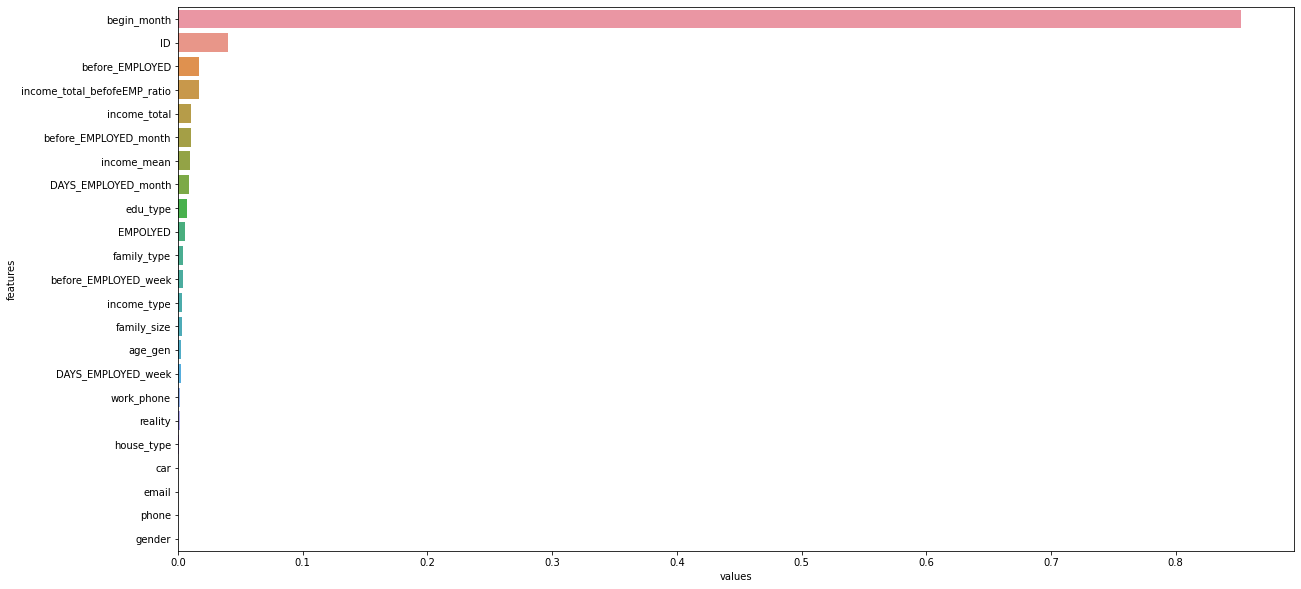

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(x='values', y='features',
            data= feature_imp.sort_values(by='values', ascending=False))
plt.show()

## RandomForest Classifier

### RandomizedSearchCV

In [ ]:
params = {
    "n_estimators" : [100, 300, 500, 1000],
    "max_depth" : [5, 10, 15, 20],
    "max_features" : [1, 3, 5, 10]
    }

In [ ]:
rf_clf = RandomForestClassifier(random_state=21)

In [ ]:
rf_rs = RandomizedSearchCV(rf_clf, param_distributions=params, n_iter=10,
                        scoring='accuracy', random_state=21, n_jobs=-1, cv=3)

In [ ]:
rf_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=21),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20],
                                        'max_features': [1, 3, 5, 10],
                                        'n_estimators': [100, 300, 500, 1000]},
                   random_state=21, scoring='accuracy')

In [ ]:
rf_rs.best_params_

{'n_estimators': 300, 'max_features': 3, 'max_depth': 20}

In [ ]:
rf_rs.best_score_

0.7145563529706785

In [ ]:
rf_pred_test = rf_rs.predict(X_test)

In [ ]:
rf_acc_score = accuracy_score(y_test, rf_pred_test)

In [ ]:
print(rf_acc_score)

0.7106060606060606


In [ ]:
print(classification_report(y_test, rf_pred_test))

              precision    recall  f1-score   support

         0.0       0.46      0.22      0.30       654
         1.0       0.65      0.43      0.52      1260
         2.0       0.74      0.91      0.82      3366

    accuracy                           0.71      5280
   macro avg       0.62      0.52      0.54      5280
weighted avg       0.68      0.71      0.68      5280



### Feature Importance

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=300, max_features=3, max_depth=20, random_state=21)

In [ ]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, max_features=3, n_estimators=300,
                       random_state=21)

In [ ]:
feature_imp = pd.DataFrame({
    'features' : X_train.columns,
    'values' : rf_clf.feature_importances_})

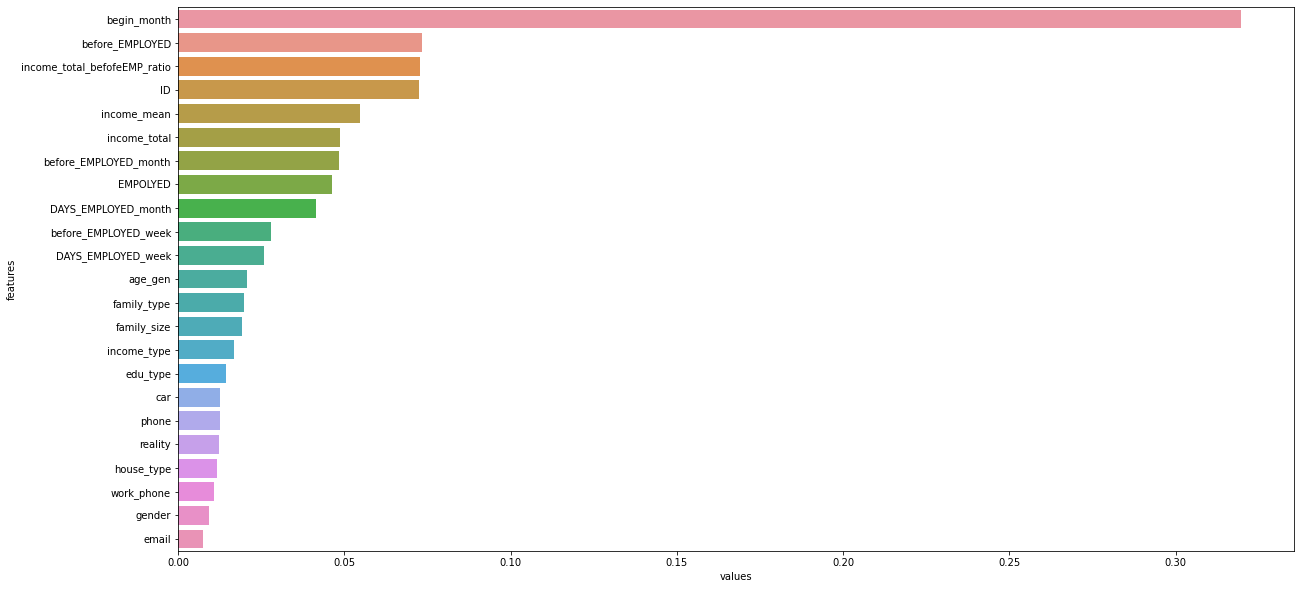

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(x='values', y='features',
            data= feature_imp.sort_values(by='values', ascending=False))
plt.show()

## XGBoost Classifier

### RandomizedSearchCV

In [ ]:
params = {
    "n_esimators": [100, 500, 1000],
    "learning_rate": [0.01, 0.05, 0.1, 0.3],
    "lambda_l1": [0, 10, 20, 30, 50],
    "lambda_l2": [0, 10, 20, 30, 50],
    "max_depth": [5, 10, 15, 20],
    "subsample": [0.6, 0.8, 1]
    }

In [ ]:
xgb_clf = XGBClassifier(random_state=21)

In [ ]:
xgb_rs = RandomizedSearchCV(xgb_clf, param_distributions=params, n_iter=10,
                            scoring='accuracy', random_state=21, n_jobs=-1, cv=3)

In [ ]:
xgb_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=XGBClassifier(random_state=21), n_jobs=-1,
                   param_distributions={'lambda_l1': [0, 10, 20, 30, 50],
                                        'lambda_l2': [0, 10, 20, 30, 50],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3],
                                        'max_depth': [5, 10, 15, 20],
                                        'n_esimators': [100, 500, 1000],
                                        'subsample': [0.6, 0.8, 1]},
                   random_state=21, scoring='accuracy')

In [ ]:
xgb_rs.best_params_

{'subsample': 0.8,
 'n_esimators': 1000,
 'max_depth': 20,
 'learning_rate': 0.01,
 'lambda_l2': 50,
 'lambda_l1': 0}

In [ ]:
xgb_rs.best_score_

0.7085899192055517

In [ ]:
xgb_pred_test = xgb_rs.predict(X_test)

In [ ]:
xgb_acc_score = accuracy_score(y_test, xgb_pred_test)

In [ ]:
print(xgb_acc_score)

0.7109848484848484


In [ ]:
print(classification_report(y_test, xgb_pred_test))

              precision    recall  f1-score   support

         0.0       0.52      0.15      0.23       654
         1.0       0.68      0.38      0.49      1260
         2.0       0.72      0.95      0.82      3366

    accuracy                           0.71      5280
   macro avg       0.64      0.49      0.51      5280
weighted avg       0.69      0.71      0.67      5280



### Feature Importance

In [ ]:
xgb_clf = XGBClassifier(subsample=0.8, n_esimators=1000, max_depth=20, 
                        learning_rate=0.01, lambda_l2=50, lambda_l1=0, random_state=21)

In [ ]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(lambda_l1=0, lambda_l2=50, learning_rate=0.01, max_depth=20,
              n_esimators=1000, objective='multi:softprob', random_state=21,
              subsample=0.8)

In [ ]:
feature_imp = pd.DataFrame({
    'features' : X_train.columns,
    'values' : xgb_clf.feature_importances_})

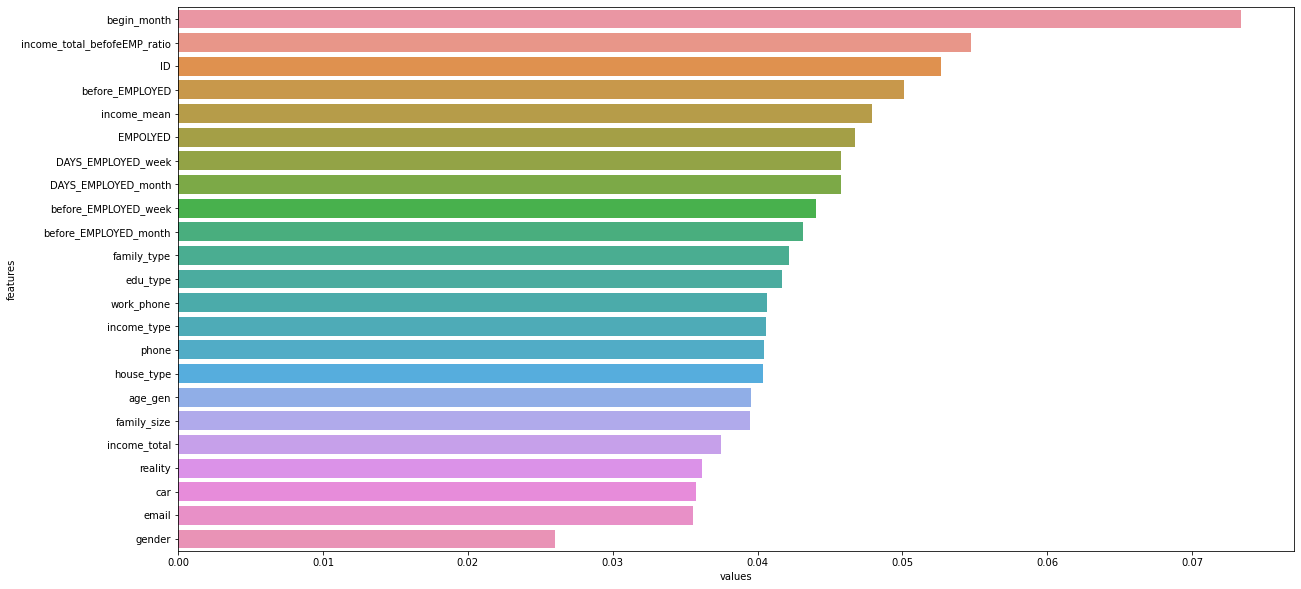

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(x='values', y='features',
            data= feature_imp.sort_values(by='values', ascending=False))
plt.show()

### HyperOpt

In [ ]:
xgb_search_space = {'max_depth':hp.quniform('max_depth', 5, 20, 1),
                    'min_child_weight':hp.quniform('min_child_weight', 1, 2, 1),
                    'learning_rate':hp.uniform('learning_rate', 0.01, 0.2),
                    'colsample_bytree':hp.uniform('colsample_bytree', 0.5, 1),
                    'subsample' : hp.quniform('subsample', 0.5, 1, 0.1),
                    'n_estimators' : hp.quniform('n_estimators', 100, 1000, 50)
                    }

In [ ]:
def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators=100,
                            max_depth=int(search_space['max_depth']),
                            learning_rate = search_space['learning_rate'],
                            subsample = search_space['subsample'],
                            min_child_weight=int(search_space['min_child_weight']),
                            colsample_bytree=search_space['colsample_bytree'],
                            eval_metric='logloss')
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)

    return {'loss':-1 * np.mean(accuracy), 'status': STATUS_OK}

In [ ]:
trial_val = Trials()
best = fmin(fn=objective_func, space=xgb_search_space,
            algo=tpe.suggest, max_evals=50, trials=trial_val, rstate=np.random.seed(21))
print('best:', best)

100%|██████████| 50/50 [39:11<00:00, 47.03s/it, best loss: -0.7212332023531235]
best: {'colsample_bytree': 0.5564799803480234, 'learning_rate': 0.04047887994754925, 'max_depth': 20.0, 'min_child_weight': 2.0, 'n_estimators': 750.0, 'subsample': 0.7000000000000001}


In [ ]:
xgb_clf = XGBClassifier(colsample_bytree=best['colsample_bytree'], 
                        learning_rate=best['learning_rate'], 
                        max_depth=int(best['max_depth']), 
                        min_child_weight=int(best['min_child_weight']), 
                        n_estimators=int(best['n_estimators']), 
                        subsample=best['subsample'], 
                        random_state=21)

In [ ]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.5564799803480234,
              learning_rate=0.04047887994754925, max_depth=20,
              min_child_weight=2, n_estimators=750, objective='multi:softprob',
              random_state=21, subsample=0.7000000000000001)

In [ ]:
xgb_clf = XGBClassifier(colsample_bytree=0.5032768898143618, 
                        learning_rate=0.07722994701360086, 
                        max_depth=16, 
                        min_child_weight=2, 
                        n_estimators=500, 
                        subsample=0.8, 
                        random_state=21)

In [ ]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.5032768898143618,
              learning_rate=0.07722994701360086, max_depth=16,
              min_child_weight=2, n_estimators=500, objective='multi:softprob',
              random_state=21, subsample=0.8)

In [ ]:
xgb_pred_test = xgb_clf.predict(X_test)

In [ ]:
xgb_acc_score = accuracy_score(y_test, xgb_pred_test)

In [ ]:
print(xgb_acc_score)

0.709659090909091


## LightGBM Classifier

### RandomizedSearchCV

In [ ]:
params = {
    "n_esimators": [100, 500, 1000],
    "learning_rate": [0.01, 0.05, 0.1, 0.3],
    "lambda_l1": [0, 10, 20, 30, 50],
    "lambda_l2": [0, 10, 20, 30, 50],
    "max_depth": [5, 10, 15, 20],
    "subsample": [0.6, 0.8, 1]
    }

In [ ]:
lgb_clf = LGBMClassifier(random_state=21)

In [ ]:
lgb_rs = RandomizedSearchCV(lgb_clf, param_distributions=params, n_iter=30,
                            scoring='accuracy', random_state=21, n_jobs=-1, cv=)

In [ ]:
lgb_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=21), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'lambda_l1': [0, 10, 20, 30, 50],
                                        'lambda_l2': [0, 10, 20, 30, 50],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3],
                                        'max_depth': [5, 10, 15, 20],
                                        'n_esimators': [100, 500, 1000],
                                        'subsample': [0.6, 0.8, 1]},
                   random_state=21, scoring='accuracy')

In [ ]:
lgb_rs.best_params_

{'subsample': 0.6,
 'n_esimators': 500,
 'max_depth': 10,
 'learning_rate': 0.3,
 'lambda_l2': 0,
 'lambda_l1': 10}

In [ ]:
lgb_rs.best_score_

0.7023392819982922

In [ ]:
lgb_pred_test = lgb_rs.predict(X_test)

In [ ]:
lgb_acc_score = accuracy_score(y_test, lgb_pred_test)

In [ ]:
print(lgb_acc_score)

0.7020833333333333


In [ ]:
print(classification_report(y_test, lgb_pred_test))

              precision    recall  f1-score   support

         0.0       0.69      0.05      0.10       654
         1.0       0.73      0.29      0.41      1260
         2.0       0.70      0.98      0.82      3366

    accuracy                           0.70      5280
   macro avg       0.71      0.44      0.44      5280
weighted avg       0.71      0.70      0.63      5280



### Feature Importance

In [ ]:
lgb_clf = LGBMClassifier(subsample=0.6, n_esimators=500, max_depth=10, 
                        learning_rate=0.3, lambda_l2=0, lambda_l1=10, random_state=21)

In [ ]:
lgb_clf.fit(X_train, y_train)

LGBMClassifier(lambda_l1=10, lambda_l2=0, learning_rate=0.3, max_depth=10,
               n_esimators=500, random_state=21, subsample=0.6)

In [ ]:
feature_imp = pd.DataFrame({
    'features' : X_train.columns,
    'values' : lgb_clf.feature_importances_})

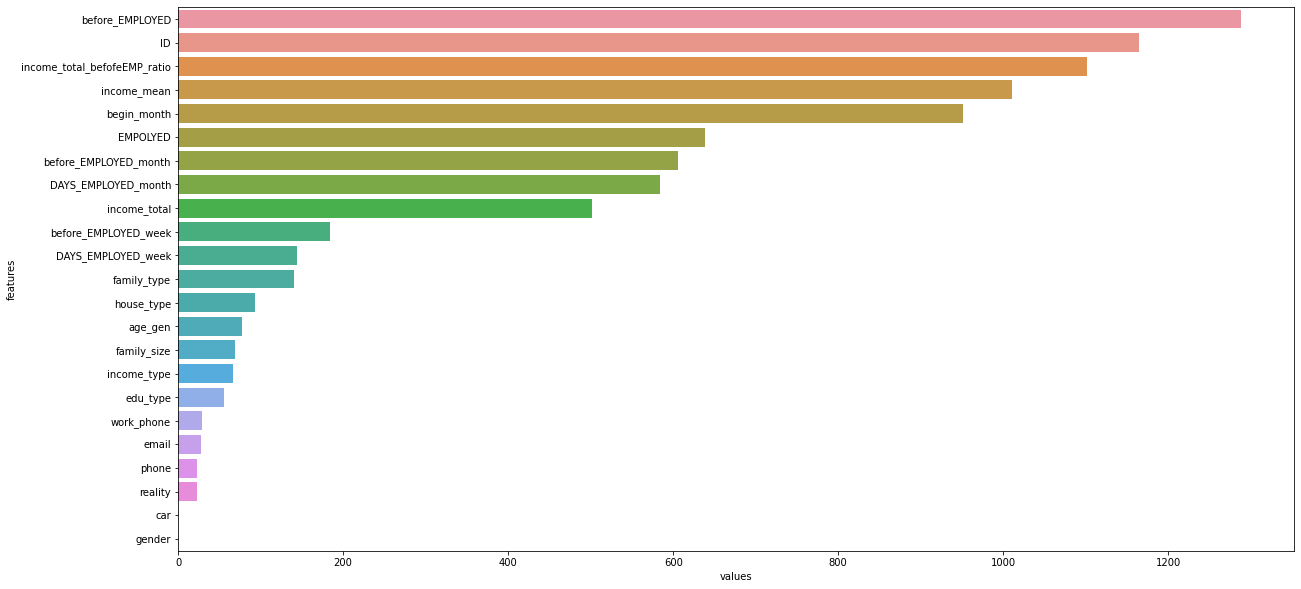

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(x='values', y='features',
            data= feature_imp.sort_values(by='values', ascending=False))
plt.show()

### HyperOpt

In [ ]:
lgb_search_space = {'max_depth':hp.quniform('max_depth', 5, 20, 1),
                    'min_child_weight':hp.quniform('min_child_weight', 1, 2, 1),
                    'learning_rate':hp.uniform('learning_rate', 0.01, 0.2),
                    'colsample_bytree':hp.uniform('colsample_bytree', 0.5, 1),
                    'subsample' : hp.quniform('subsample', 0.5, 1, 0.1),
                    'n_estimators' : hp.quniform('n_estimators', 100, 1000, 50)
                    }

In [ ]:
def objective_func(search_space):
    lgb_clf = LGBMClassifier(n_estimators=100,
                            max_depth=int(search_space['max_depth']),
                            learning_rate = search_space['learning_rate'],
                            subsample = search_space['subsample'],
                            min_child_weight=int(search_space['min_child_weight']),
                            colsample_bytree=search_space['colsample_bytree'],
                            eval_metric='logloss')
    accuracy = cross_val_score(lgb_clf, X_train, y_train, scoring='accuracy', cv=3)

    return {'loss':-1 * np.mean(accuracy), 'status': STATUS_OK}

In [ ]:
trial_val = Trials()
best = fmin(fn=objective_func, space=lgb_search_space,
            algo=tpe.suggest, max_evals=50, trials=trial_val, rstate=np.random.seed(21))
print('best:', best)

100%|██████████| 50/50 [02:10<00:00,  2.60s/it, best loss: -0.7072639867383884]
best: {'colsample_bytree': 0.6898019152262602, 'learning_rate': 0.1859450472032707, 'max_depth': 18.0, 'min_child_weight': 2.0, 'n_estimators': 300.0, 'subsample': 1.0}


In [ ]:
lgb_clf = LGBMClassifier(colsample_bytree=best['colsample_bytree'], 
                        learning_rate=best['learning_rate'], 
                        max_depth=int(best['max_depth']), 
                        min_child_weight=int(best['min_child_weight']), 
                        n_estimators=int(best['n_estimators']), 
                        subsample=best['subsample'], 
                        random_state=21)

In [ ]:
lgb_clf.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.6898019152262602,
               learning_rate=0.1859450472032707, max_depth=18,
               min_child_weight=2, n_estimators=300, random_state=21)

In [ ]:
lgb_pred_test = lgb_clf.predict(X_test)

In [ ]:
lgb_acc_score = accuracy_score(y_test, lgb_pred_test)

In [ ]:
print(lgb_acc_score)

0.7126893939393939


## CatBoost Classifier

### Type : to Integer
* float Type이 있으면 Optuna 실행 시 에러 발생

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26398 entries, 0 to 26397
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        26398 non-null  int64  
 1   car                           26398 non-null  int64  
 2   reality                       26398 non-null  int64  
 3   income_total                  26398 non-null  float64
 4   income_type                   26398 non-null  int64  
 5   edu_type                      26398 non-null  int64  
 6   family_type                   26398 non-null  int64  
 7   house_type                    26398 non-null  int64  
 8   work_phone                    26398 non-null  int64  
 9   phone                         26398 non-null  int64  
 10  email                         26398 non-null  int64  
 11  family_size                   26398 non-null  float64
 12  begin_month                   26398 non-null  float64
 13  c

In [ ]:
float_cols = ['income_total', 'family_size', 'begin_month', 'credit', 'income_mean', 'income_total_befofeEMP_ratio', 'before_EMPLOYED_month', 'before_EMPLOYED_week', 'DAYS_EMPLOYED_month', 'DAYS_EMPLOYED_week']

for col in float_cols:
    train[col] = train[col].astype(int)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26398 entries, 0 to 26397
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   gender                        26398 non-null  int64
 1   car                           26398 non-null  int64
 2   reality                       26398 non-null  int64
 3   income_total                  26398 non-null  int64
 4   income_type                   26398 non-null  int64
 5   edu_type                      26398 non-null  int64
 6   family_type                   26398 non-null  int64
 7   house_type                    26398 non-null  int64
 8   work_phone                    26398 non-null  int64
 9   phone                         26398 non-null  int64
 10  email                         26398 non-null  int64
 11  family_size                   26398 non-null  int64
 12  begin_month                   26398 non-null  int64
 13  credit                        2

In [ ]:
data_X = train.drop('credit', axis=1)
data_y = train[['credit']]

In [ ]:
data_X.shape, data_y.shape

((26398, 23), (26398, 1))

### Train, Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, random_state=21)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21118, 23), (5280, 23), (21118, 1), (5280, 1))

### Optuna

In [ ]:
def objective(trial):
  param = {
      "random_state":21,
      'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),
      'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
      "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
      "max_depth":trial.suggest_int("max_depth", 4, 16),
      'random_strength' :trial.suggest_int('random_strength', 0, 100),
      "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
      "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
      "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
      "max_bin": trial.suggest_int("max_bin", 200, 500),
      'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
  }

  cat_features =[0,1,2,5,6,7,8,15,18]
  cat_clf = CatBoostClassifier(**param)
  cat_clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
              early_stopping_rounds=35, cat_features=cat_features,
              verbose=100)
  cat_pred_test = cat_clf.predict(X_test)
  cat_acc_score = accuracy_score(y_test, cat_pred_test)

  return cat_acc_score

In [ ]:
sampler = TPESampler(seed=21)

In [ ]:
study = optuna.create_study(study_name = 'cat_parameter_opt',
                            direction = 'minimize',
                            sampler = sampler
                            )

[I 2023-01-03 07:13:04,063] A new study created in memory with name: cat_parameter_opt


In [ ]:
study.optimize(objective, n_trials=10)

0:	learn: 1.0933123	test: 1.0933123	test1: 1.0934001	best: 1.0934001 (0)	total: 12.5ms	remaining: 1m 33s
100:	learn: 0.8859465	test: 0.8747788	test1: 0.8888472	best: 0.8888472 (100)	total: 1.02s	remaining: 1m 14s
200:	learn: 0.8405800	test: 0.8001799	test1: 0.8396582	best: 0.8396582 (200)	total: 1.91s	remaining: 1m 9s
300:	learn: 0.8138684	test: 0.7430771	test1: 0.8079241	best: 0.8079241 (300)	total: 2.85s	remaining: 1m 8s
400:	learn: 0.7949942	test: 0.7002306	test1: 0.7849161	best: 0.7849161 (400)	total: 3.78s	remaining: 1m 6s
500:	learn: 0.7838042	test: 0.6730823	test1: 0.7711444	best: 0.7711441 (498)	total: 4.75s	remaining: 1m 6s
600:	learn: 0.7765709	test: 0.6532812	test1: 0.7618895	best: 0.7618895 (600)	total: 5.79s	remaining: 1m 6s
700:	learn: 0.7686458	test: 0.6333540	test1: 0.7520148	best: 0.7520148 (700)	total: 6.74s	remaining: 1m 5s
800:	learn: 0.7621963	test: 0.6181128	test1: 0.7444416	best: 0.7444416 (800)	total: 7.75s	remaining: 1m 4s
900:	learn: 0.7552754	test: 0.6024696	

[I 2023-01-03 07:13:28,635] Trial 0 finished with value: 0.725189393939394 and parameters: {'learning_rate': 0.011802460539416873, 'bagging_temperature': 0.14336351455044888, 'n_estimators': 7489, 'max_depth': 4, 'random_strength': 20, 'colsample_bylevel': 0.4304639540172261, 'l2_leaf_reg': 9.075134099998858e-06, 'min_child_samples': 68, 'max_bin': 292, 'od_type': 'IncToDec'}. Best is trial 0 with value: 0.725189393939394.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.6999966656
bestIteration = 2158

Shrink model to first 2159 iterations.
0:	learn: 1.0209719	test: 1.0209719	test1: 1.0223443	best: 1.0223443 (0)	total: 9.19ms	remaining: 23.9s
100:	learn: 0.6171312	test: 0.5001074	test1: 0.7124023	best: 0.7085878 (82)	total: 3.58s	remaining: 1m 28s


[I 2023-01-03 07:13:33,517] Trial 1 finished with value: 0.7172348484848485 and parameters: {'learning_rate': 0.19110040160607733, 'bagging_temperature': 0.034116311964429, 'n_estimators': 2603, 'max_depth': 10, 'random_strength': 87, 'colsample_bylevel': 0.8553663013072685, 'l2_leaf_reg': 2.9114848909221238e-05, 'min_child_samples': 77, 'max_bin': 315, 'od_type': 'Iter'}. Best is trial 1 with value: 0.7172348484848485.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.7085878271
bestIteration = 82

Shrink model to first 83 iterations.
0:	learn: 1.0854786	test: 1.0854786	test1: 1.0870175	best: 1.0870175 (0)	total: 244ms	remaining: 37m 31s
100:	learn: 0.5729477	test: 0.5850079	test1: 0.7900810	best: 0.7900810 (100)	total: 22.4s	remaining: 33m 40s
200:	learn: 0.4086429	test: 0.4310983	test1: 0.7767292	best: 0.7753010 (171)	total: 44.3s	remaining: 33m 5s


[I 2023-01-03 07:14:19,486] Trial 2 finished with value: 0.6901515151515152 and parameters: {'learning_rate': 0.025107997354865165, 'bagging_temperature': 26.086240143251988, 'n_estimators': 9219, 'max_depth': 13, 'random_strength': 52, 'colsample_bylevel': 0.5007014591329044, 'l2_leaf_reg': 8.967781825349882e-06, 'min_child_samples': 32, 'max_bin': 298, 'od_type': 'Iter'}. Best is trial 2 with value: 0.6901515151515152.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.7753009904
bestIteration = 171

Shrink model to first 172 iterations.
0:	learn: 1.0828337	test: 1.0836439	test1: 1.0877390	best: 1.0877390 (0)	total: 1.2s	remaining: 2h 30m 26s
100:	learn: 0.4646923	test: 0.4878323	test1: 0.7811739	best: 0.7811739 (100)	total: 1m 54s	remaining: 2h 20m 9s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.7753692982
bestIteration = 128

Shrink model to first 129 iterations.


[I 2023-01-03 07:17:26,856] Trial 3 finished with value: 0.6859848484848485 and parameters: {'learning_rate': 0.02094727072011249, 'bagging_temperature': 15.829722723991496, 'n_estimators': 7540, 'max_depth': 15, 'random_strength': 27, 'colsample_bylevel': 0.7688948266890607, 'l2_leaf_reg': 1.9586154635087733e-05, 'min_child_samples': 42, 'max_bin': 323, 'od_type': 'IncToDec'}. Best is trial 3 with value: 0.6859848484848485.


0:	learn: 1.0103684	test: 1.0104184	test1: 1.0125594	best: 1.0125594 (0)	total: 20.5ms	remaining: 2m 53s


[I 2023-01-03 07:18:17,881] Trial 4 finished with value: 0.7178030303030303 and parameters: {'learning_rate': 0.21230372201690825, 'bagging_temperature': 0.9122815676946686, 'n_estimators': 8455, 'max_depth': 15, 'random_strength': 79, 'colsample_bylevel': 0.9325932623243218, 'l2_leaf_reg': 2.096883506068512e-05, 'min_child_samples': 48, 'max_bin': 292, 'od_type': 'IncToDec'}. Best is trial 3 with value: 0.6859848484848485.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.723604091
bestIteration = 64

Shrink model to first 65 iterations.
0:	learn: 1.0813288	test: 1.0813288	test1: 1.0816068	best: 1.0816068 (0)	total: 9.45ms	remaining: 59.6s
100:	learn: 0.8044784	test: 0.7142061	test1: 0.7983897	best: 0.7983897 (100)	total: 11.9s	remaining: 12m 11s
200:	learn: 0.7602904	test: 0.6165832	test1: 0.7525294	best: 0.7525294 (200)	total: 25.8s	remaining: 13m 5s
300:	learn: 0.7202669	test: 0.5622901	test1: 0.7222173	best: 0.7222173 (300)	total: 42.9s	remaining: 14m 17s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.7053935407
bestIteration = 362

Shrink model to first 363 iterations.


[I 2023-01-03 07:20:22,519] Trial 5 finished with value: 0.7274621212121212 and parameters: {'learning_rate': 0.039152868643598904, 'bagging_temperature': 0.08411031506090014, 'n_estimators': 6314, 'max_depth': 15, 'random_strength': 33, 'colsample_bylevel': 0.8827657912117888, 'l2_leaf_reg': 2.3925610655644766e-05, 'min_child_samples': 68, 'max_bin': 273, 'od_type': 'IncToDec'}. Best is trial 3 with value: 0.6859848484848485.


0:	learn: 1.0464137	test: 1.0464139	test1: 1.0472565	best: 1.0472565 (0)	total: 17.1ms	remaining: 2m 29s
100:	learn: 0.6664525	test: 0.5283895	test1: 0.7177718	best: 0.7169663 (98)	total: 7.06s	remaining: 10m 6s


[I 2023-01-03 07:20:38,613] Trial 6 finished with value: 0.7208333333333333 and parameters: {'learning_rate': 0.12352453001842968, 'bagging_temperature': 0.6959625541603731, 'n_estimators': 8777, 'max_depth': 13, 'random_strength': 16, 'colsample_bylevel': 0.5075478838751012, 'l2_leaf_reg': 2.5498651806217224e-05, 'min_child_samples': 40, 'max_bin': 314, 'od_type': 'Iter'}. Best is trial 3 with value: 0.6859848484848485.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.7146000096
bestIteration = 104

Shrink model to first 105 iterations.
0:	learn: 1.0346687	test: 1.0346687	test1: 1.0357661	best: 1.0357661 (0)	total: 5.25ms	remaining: 14.4s


[I 2023-01-03 07:21:07,236] Trial 7 finished with value: 0.6910984848484848 and parameters: {'learning_rate': 0.1541235210580161, 'bagging_temperature': 38.83752900116128, 'n_estimators': 2753, 'max_depth': 15, 'random_strength': 17, 'colsample_bylevel': 0.624112659190208, 'l2_leaf_reg': 1.1474540044100993e-05, 'min_child_samples': 59, 'max_bin': 353, 'od_type': 'IncToDec'}. Best is trial 3 with value: 0.6859848484848485.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.7746036906
bestIteration = 39

Shrink model to first 40 iterations.
0:	learn: 1.0041885	test: 1.0041885	test1: 1.0064315	best: 1.0064315 (0)	total: 20.3ms	remaining: 58.4s


[I 2023-01-03 07:21:36,555] Trial 8 finished with value: 0.7145833333333333 and parameters: {'learning_rate': 0.2379557190404017, 'bagging_temperature': 0.09689552854019028, 'n_estimators': 2874, 'max_depth': 14, 'random_strength': 30, 'colsample_bylevel': 0.8052354345477224, 'l2_leaf_reg': 2.7710504866843485e-05, 'min_child_samples': 11, 'max_bin': 435, 'od_type': 'Iter'}. Best is trial 3 with value: 0.6859848484848485.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.7184865729
bestIteration = 56

Shrink model to first 57 iterations.
0:	learn: 1.0726224	test: 1.0726224	test1: 1.0730458	best: 1.0730458 (0)	total: 17.9ms	remaining: 2m 23s
100:	learn: 0.7639435	test: 0.6547135	test1: 0.7533116	best: 0.7533116 (100)	total: 1.48s	remaining: 1m 56s
200:	learn: 0.7466324	test: 0.6052133	test1: 0.7349991	best: 0.7349991 (200)	total: 2.99s	remaining: 1m 56s
300:	learn: 0.7373842	test: 0.5805516	test1: 0.7271755	best: 0.7271755 (300)	total: 4.48s	remaining: 1m 54s
400:	learn: 0.7304058	test: 0.5671402	test1: 0.7228254	best: 0.7228118 (399)	total: 5.97s	remaining: 1m 53s
500:	learn: 0.7254680	test: 0.5588063	test1: 0.7212736	best: 0.7212736 (500)	total: 7.49s	remaining: 1m 52s
600:	learn: 0.7208395	test: 0.5536937	test1: 0.7201139	best: 0.7201139 (600)	total: 8.98s	remaining: 1m 50s
700:	learn: 0.7153552	test: 0.5496782	test1: 0.7189250	best: 0.7189250 (700)	total: 10.4s	remaining: 1m 48s
800

[I 2023-01-03 07:21:49,244] Trial 9 finished with value: 0.718939393939394 and parameters: {'learning_rate': 0.04447833353458208, 'bagging_temperature': 5.782120413243453, 'n_estimators': 8013, 'max_depth': 4, 'random_strength': 7, 'colsample_bylevel': 0.7629067233415172, 'l2_leaf_reg': 2.1373376580169998e-05, 'min_child_samples': 19, 'max_bin': 385, 'od_type': 'Iter'}. Best is trial 3 with value: 0.6859848484848485.


Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.7183557288
bestIteration = 798

Shrink model to first 799 iterations.


In [ ]:
print("Best Score:",study.best_value)
print("Best trial",study.best_trial.params)

Best Score: 0.6859848484848485
Best trial {'learning_rate': 0.02094727072011249, 'bagging_temperature': 15.829722723991496, 'n_estimators': 7540, 'max_depth': 15, 'random_strength': 27, 'colsample_bylevel': 0.7688948266890607, 'l2_leaf_reg': 1.9586154635087733e-05, 'min_child_samples': 42, 'max_bin': 323, 'od_type': 'IncToDec'}


In [ ]:
cat_clf = CatBoostClassifier(**study.best_params)

In [ ]:
cat_features =[0,1,2,5,6,7,8,15,18]
cat_clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
              early_stopping_rounds=35, cat_features=cat_features, verbose=100)

0:	learn: 1.0821505	test: 1.0826574	test1: 1.0867871	best: 1.0867871 (0)	total: 1.08s	remaining: 2h 16m 4s
100:	learn: 0.4629804	test: 0.5094248	test1: 0.7771693	best: 0.7771693 (100)	total: 1m 55s	remaining: 2h 21m 40s
200:	learn: 0.2649350	test: 0.3634210	test1: 0.7701051	best: 0.7678129 (174)	total: 3m 52s	remaining: 2h 21m 33s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.7678128735
bestIteration = 174

Shrink model to first 175 iterations.


In [ ]:
cat_pred_test = cat_clf.predict(X_test)

In [ ]:
cat_acc_score = accuracy_score(y_test, cat_pred_test)

In [ ]:
print(cat_acc_score)

0.6924242424242424


In [ ]:
print(classification_report(y_test, cat_pred_test))

              precision    recall  f1-score   support

           0       0.46      0.16      0.24       654
           1       0.62      0.35      0.45      1260
           2       0.72      0.92      0.81      3366

    accuracy                           0.69      5280
   macro avg       0.60      0.48      0.50      5280
weighted avg       0.66      0.69      0.65      5280



### Feature Importance

In [ ]:
feature_imp = pd.DataFrame({
    'features' : X_train.columns,
    'values' : cat_clf.feature_importances_})

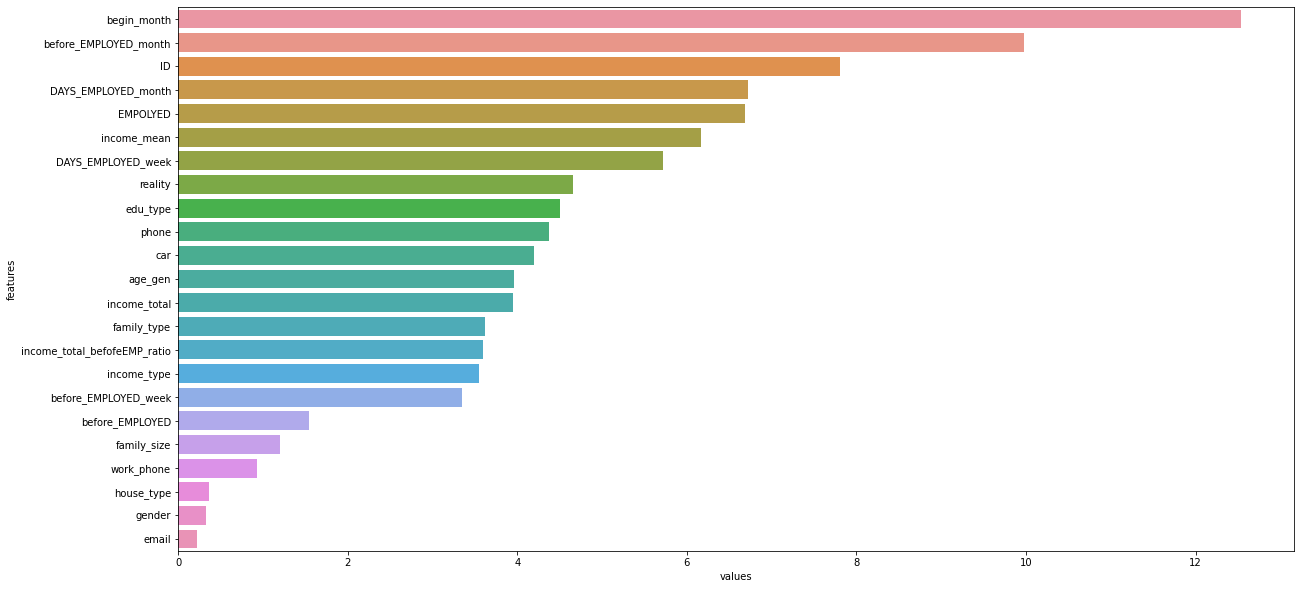

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(x='values', y='features',
            data= feature_imp.sort_values(by='values', ascending=False))
plt.show()

# Conclusion
> CV : sklearn stratifiedkfold